<br/>
  <FONT size ="3pt"> MODAL MAP472A : Problem solving en math app </FONT>   
  
---
---
<FONT size ="5pt"> TP déterministe 1 : <center><b>Problème aux valeurs propres</b>  </center></FONT> 

---
---
<br /> 

In [21]:
# importation de fonctions et de librairies
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve, qr
from tqdm import tqdm

Dans ce TP, on va étudier plusieurs méthodes numérique pour la recherche de valeurs propres et de vecteurs propres, c'est à dire pour une matrice $A\in\mathbb{R}^{N\times N}$, on cherche un ou tous les $\lambda\in\mathbb{R}$ et $V\in\mathbb{R}^N$ tels que

$$AV = \lambda V.$$

On pourra dans un premier temps tester ces méthodes sur les matrices de la forme (pour différentes valeurs de $N$) :

In [2]:
def Laplacien(N):
    #construit la matrice du Laplacien 1D
    return 2*np.eye(N) - np.diag(np.ones(N-1),1) - np.diag(np.ones(N-1),-1)

print("Laplacien(3) :\n", Laplacien(3))

Laplacien(3) :
 [[ 2. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  2.]]


On appliquera dans un second temps ces méthodes pour étudier les ondes émises par un tambour et on étudiera alors les valeurs propres du Laplacien 2D discrétisé. 


On notera $\|V\| = \sqrt{V^T V}$ dans tout ce TP.  

# Méthode de la puissance
La méthode de la puissance consiste à multiplier itérativement un vecteur par la matrice $A$ afin de récupérer sa plus grande valeur propre. L'algorithme prend la forme
- **Initialisation** : Choix d'un vecteur $V^0\in\mathbb{R}^N$ de norme $\|V^0\| = 1$.
- **Itération** : Calculer $$W^{i+1} = A V^0, \qquad V^{i+1} = \frac{W^{i+1}}{ \|W^{i+1}\|}$$ jusqu'à convergence. 

1. Implémenter cet algorithme et le tester avec la matrice du Laplacien $L\in\mathbb{R}^{N\times N}$ pour $N = 50$ avec un critère de tolérance de $10^{-3}$. Puis avec un critère de tolérance de $10^{-12}$.

In [14]:
def puissance(
    A : np.ndarray, 
    V : np.ndarray, 
    N_max : int = 10_000, 
    TOL : float = 1e-10
):
    """
    Renvoie une valeur propre approchée de A par la méthode de la puissance
    ----------   
    Paramètres :
    A     : matrice
    V     : vecteur initial 
    N_max : nombre maximum d'itérations
    TOL   : tolérance pour le critère d'arrêt
    
    Retourne :
    -Valeur propre approchée à la fin des itérations
    -Vecteur propre associé
    -Vecteur contenant l'erreur à chaque itération pour étudier la convergence
    """
    W_i = A @ V
    V_i = V
    err = []
    eigenvalue = np.inf
    for n_inter in range(N_max):
        eigenvalue = np.mean((A@ V_i )/ V_i)
        err_i = np.linalg.norm((A@ V_i ) - eigenvalue * V_i)
        err.append(err_i)

        V_i1 = W_i / np.linalg.norm(W_i)

        if err_i < TOL:
            return eigenvalue, V_i, err

        V_i = V_i1
        W_i = A @ V_i
    return 

In [84]:
A = Laplacien(50)
V = np.random.rand(A.shape[0])
V = V / np.linalg.norm(V)

eigenvalue, V_i, err = puissance(
    A, 
    V, 
)

In [85]:
# On commence par tester l'algorithme sur un cas trivial que l'on peut vérifier !
# 1.b Proposer un/des cas test (matrice, vecteur initiale...) pour tester votre algorithme

random_matrix = np.random.rand(50,50)
eig, _ = np.linalg.eig(random_matrix)
abs_eig = np.abs(eig)
max_abs_eig = np.max(abs_eig) 

test_cases = {
    "Identity of size 10": {
        "A" : np.eye(10),
        "lambda" : 1
    },

    # "Zero matrix of size 10" : {
    #     "A": np.zeros((10,10)),
    #     "lambda" : 0
    # },

    "Matrix of ones size 50": {
        "A": np.ones((50,50)),
        "lambda": np.max(np.abs(np.linalg.eig(np.ones((50,50)))[0]))
    },

    "Random matrix of size 50": {
        "A" : random_matrix,
        "lambda" : max_abs_eig
    }
}

for name, test_case in test_cases.items():
    A = test_case["A"]
    V = np.random.rand(A.shape[0])
    V = V / np.linalg.norm(V)

    eigenvalue, V_i, err = puissance(
        A, 
        V,    
    )
    
    if (abs(eigenvalue - test_case["lambda"]) > 1e-3):
        print(
        f"""
        Test case: {name}
        Test failed
        real eigenvalue: {test_case["lambda"]}
        calculated eigenvalue: {eigenvalue}
        """
        )

    else:
        print(
        f"""
        Test case: {name}
        Test success
        real eigenvalue: {test_case["lambda"]}
        calculated eigenvalue: {eigenvalue}
        """
        )




        Test case: Identity of size 10
        Test success
        real eigenvalue: 1
        calculated eigenvalue: 1.0
        

        Test case: Matrix of ones size 50
        Test success
        real eigenvalue: 50.0
        calculated eigenvalue: 49.99999999999999
        

        Test case: Random matrix of size 50
        Test success
        real eigenvalue: 25.146703592869365
        calculated eigenvalue: 25.146703592869248
        


2. En supposant que l'algorithme converge vers une solution $V^{\infty} = \frac{A V^\infty}{ \|AV^\infty\|}$, comment obtenir la valeur propre associée? Proposer un critère de convergence pour l'algorithme.
---



$$ 
    V^{i+1} = \frac{A V^{i}}{|A V^{i}|}
$$

$$
    V^{1} =  \frac{A V^{0}}{|A V^{0}|}
$$

In [71]:
A = np.ones([50,50])
V = np.random.rand(A.shape[0])
V = V/np.linalg.norm(V)

eigenvalue, V_inf, err = puissance(
    A, 
    V, 
    N_max = 100_000,
    TOL = 1e-15
)

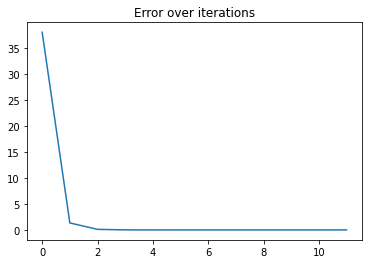

In [86]:
plt.title("Error over iterations")
plt.plot(err)

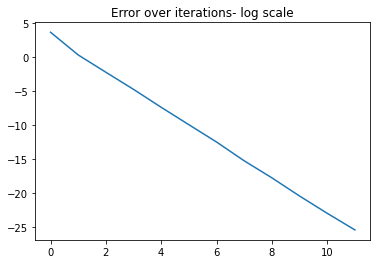

In [87]:
plt.title("Error over iterations- log scale")
plt.plot(np.log(err))

In [77]:
np.max(A @ V_inf / V_inf)

49.99999999999999

3. En supposant que $A$ est symétrique définie positive, montrer que l'algorithme converge et donner son taux de convergence. 
---


Si $A$ est symétrique définie positive, $A$ est diagonalizable, *i.e.*, les vecteurs propres de $A$ $v_1, v_2, \dots v_n$ sont LI et donc forment une base de $M_n(\mathbb{R})$.

En définissant $v_1, v_2, \dots, v_n$ comme 

$$
    |v_1| > |v_2| \geq |v_3| \geq \dots \geq |v_n|  
$$  

Alors, 


$$
\begin{aligned}
    \frac{A V} {|A V|} &= a_1 (A v_1) + a_2 (A v_2) + \dots + a_n (A v_n) \\
        & = a_1 (\lambda_1 v_1 ) + \dots + a_n (\lambda_n v_n)

\end{aligned}
$$

De même

$$
\begin{aligned}
    \frac{A^k V} {|A^k V|} &= a_1 (A^k v_1) + a_2 (A^k v_2) + \dots + a_n (A^k v_n) \\
        & = a_1 (\lambda_1^k v_1 ) + \dots + a_n (\lambda_n^k v_n) \\
        & = \lambda_1^k \left( a_1 v_1 + a_2 \frac{\lambda_2^k}{\lambda_1^k} v_2 + \dots + a_n \frac{\lambda_n^k}{\lambda_1^k} v_n \right)

\end{aligned}
$$

À la limite $k \rarr \infty$

$$
    V ^\infty = \frac{A^k V} {|A^k V|} \propto  v_1
$$

Et on a trouvé le vecteur propre $v_1$

4. Tracer les courbes de convergence avec les matrices *Laplacien(10)*. Évaluer numériquement le taux de convergence de l'algorithme. Qu'en déduire sur la seconde valeur propre de ces matrices?

In [79]:
# Cas test Laplacien(10)
L_10 = Laplacien(10)

eig, _ = np.linalg.eig(L_10)
abs_eig = np.abs(eig)
max_abs_eig = np.max(abs_eig)

test_cases = {
    "Laplacien(10)" : {
        "A": Laplacien(10),
        "lambda": max_abs_eig
    }
}


for name, test_case in test_cases.items():
    A = test_case["A"]
    V = np.random.rand(A.shape[0])
    V = V / np.linalg.norm(V)

    eigenvalue, V_i, err = puissance(
        A, 
        V,    
    )
    
    if (abs(eigenvalue - test_case["lambda"]) > 1e-5):
        print(
        f"""
        Test case: {name}
        Test failed
        real eigenvalue: {test_case["lambda"]}
        calculated eigenvalue: {eigenvalue}
        """
        )

    else:
        print(
        f"""
        Test case: {name}
        Test success
        real eigenvalue: {test_case["lambda"]}
        calculated eigenvalue: {eigenvalue}
        """
        )




        Test case: Laplacien(10)
        Test success
        real eigenvalue: 3.9189859472289967
        calculated eigenvalue: 3.9189859472289954
        


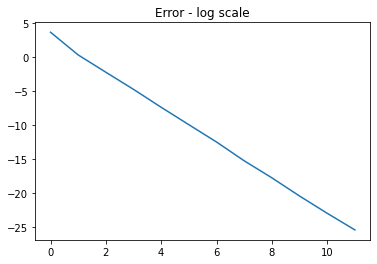

In [100]:
# calcul d'erreur
log_err = np.log(err)

plt.title("Error - log scale")
plt.plot(log_err)

err_tax = np.mean(np.diff(log_err))

In [102]:
err_tax

-2.643753839103678

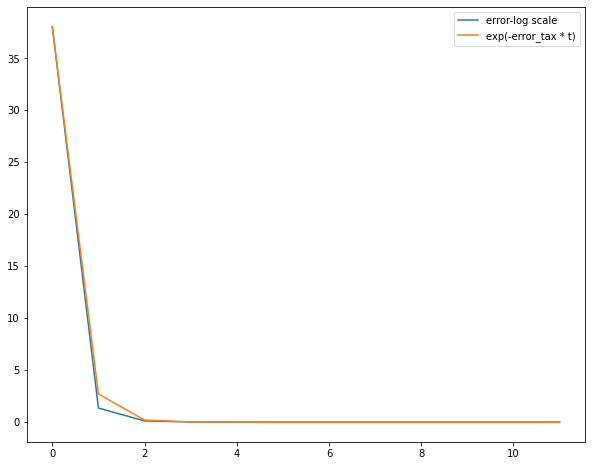

In [108]:
plt.figure(figsize = (10,8))
plt.plot(
    err,
    label = "error-log scale"
)
plt.plot(
    [err[0]*np.exp(err_tax*t) for t in range(len(err))],
    label = "exp(-error_tax * t)"
)

plt.legend()

# Son d'un tambour

On peut relier la description des ondes accoustiques produites à la déformation périodique de l'objet qui l'a produit. Ces ondes de déformation sont généralement régies par l'équation des ondes 

$$\partial_t^2 d - \Delta_x d = 0.$$ 

En faisant une hypothèse de séparation des variables $d(t,x) = H(t)D(x)$, on arrive à un problème aux valeurs propres suivant 

- "Chercher $\lambda$ et $D(x)$ tels que $\Delta_x D = \lambda D$".

En 1D, l'exemple type de la corde vibrante peut se résoudre analytiquement menant à une solution sinusoïdale dont la période dépend des conditions de bord.

On va s'intéresser ici au cas 2D discret et chercher à tracer les courbes de Chladni, isocontours de la fonction $D(x)$. 

1. a) On écrit le Laplacien discret en 2D comme 

$$\Delta_x D(x_{i,j}) \approx (L D)_{i,j} = \frac{1}{\Delta_x^2} \left(-D_{i+1,j}+2D_{i,j}-D_{i-1,j}\right) + \frac{1}{\Delta_y^2} \left(-D_{i,j+1}+2D_{i,j}-D_{i,j-1}\right),$$

où $D_{i,j} \approx D(x_{i,j})$ et $L$ est le Laplacien discrétisé. On cherche désormais à résoudre $L D = \lambda D$. 

Pour le moment, on imposera des conditions de bord de type Dirichlet $D(0,y) = 0 = D(1,y) = D(x,0) = D(x,1).$

On réécrit $D_{i,j}$ sous la forme d'un vecteur $\tilde{D}_l$. Écrire la matrice du Laplacien 2D avec ces conditions de bord, i.e. la matrice $\tilde{L}$ telle que $(\tilde{L} \tilde{D})_l = (L D)_{i,j}$.

*On pourra réutiliser cette construction ultérieurement.*

---

b) Implémenter la construction de cette matrice. *Par simplicité, on pourra fixer le nombre de maille $N$ en $x$ et en $y$ égaux et on multipliera l'équation par $\frac{1}{\Delta x^2}$ pour ne faire apparaitre que des entiers dans cette matrice.* 

In [11]:
n = 4
M = np.zeros((n**2,n**2))

for i in range(n**2):
    for j in range(n**2):
        if (i == j):
            M[i,j] = 4
            continue
        
        if abs(i - j) == 1:
            if (min(i,j ) +1) % n != 0:
                M[i,j] = -1
            continue

        if abs(i-j) == n:
            M[i,j ] = -1


In [13]:
def Laplacien_2D_Dirichlet(N):
    """
    Renvoie la matrice (carrée) du Laplacien 2D avec des conditions de Dirichlet au bord
    ----------   
    Paramètres :
    N     : nb de pas d'espace dans une direction
    
    Retourne :
    - matrice du Laplacien 2D sur un carré
    """

    M = np.zeros((N**2,N**2))

    for i in range(N**2):
        for j in range(N**2):
            if (i == j):
                M[i,j] = 4
                continue
            
            if abs(i - j) == 1:
                if (min(i,j ) +1) % N != 0:
                    M[i,j] = -1
                continue

            if abs(i-j) == N:
                M[i,j ] = -1
    return M

print("Laplacien 2D(3) :\n", Laplacien_2D_Dirichlet(3))

Laplacien 2D(3) :
 [[ 4. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  4.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  4. -1.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  4.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  4. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  4.]]


2. a) Calculer la 1e valeur propre du Laplacien pour différentes valeurs de $N$. 

b) Tracer les isocontours de $D$. 
Le contour de déplacement $D=0$ correspond aux positions qui ne sont pas déplacées par cette oscillation. 

In [22]:
# Cas test du Laplacien 2D
eigenvalues= {}

for N in tqdm(range(1,30 +1)):
    A = Laplacien_2D_Dirichlet(N)
    V = np.random.rand(A.shape[0])
    V = V / np.linalg.norm(V)

    eigenvalue, V_i, err = puissance(
        A, 
        V,    
    )

    eigenvalues[N] =eigenvalue 



  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


In [23]:
eigenvalues

{1: 4.0,
 2: 6.0,
 3: 6.82842712474619,
 4: 7.23606797749979,
 5: 7.464101615137755,
 6: 7.603875471609675,
 7: 7.695518130045146,
 8: 7.758770483143633,
 9: 7.804226065180613,
 10: 7.837971894457988,
 11: 7.863703305156274,
 12: 7.883767269704208,
 13: 7.899711648727294,
 14: 7.912590402935224,
 15: 7.92314112161292,
 16: 7.931892398735608,
 17: 7.9392310120488325,
 18: 7.945445213610888,
 19: 7.95075336238055,
 20: 7.9553233049005145,
 21: 7.959285767523731,
 22: 7.9627437841453235,
 23: 7.965779445495241,
 24: 7.968458805257912,
 25: 7.970835496392216,
 26: 7.972953430967771,
 27: 7.97484883957297,
 28: 7.976551828617438,
 29: 7.978087581473093,
 30: 7.979477293567581}

In [ ]:
# courbe de contour de D en 2D



# D'autres méthodes de puissance
On veut maintenant aller plus loin et calculer d'autres valeurs propres et vecteurs propres. 

## Méthode de la puissance inverse
Soit $\mu\in\mathbb{R}$ une première estimation d'une valeur propre $\lambda$ de $A$ (qui peut ou non être $\lambda_1$).

1. On suppose que $0 < |\mu-\lambda| < |\mu-\lambda_i|$ pour toute autre valeur propre $\lambda_i\neq \lambda$. Comment peut on relier la plus grande valeur propre de $(A-\mu Id)^{-1}$ à $\lambda$? Comment relier les vecteurs propres associés?
---

2. Utiliser la méthode de la puissance sur $(A-\mu Id)^{-1}$ pour calculer $\lambda$ pour la matrice $L$ avec $N=10$ pour un $\mu$ choisi. 

*Indications :* Le calcul de l'inverse $(A-\mu Id)^{-1}$ est également complexe dans le cas général et nécessite un algorithme en lui même. Ici, on pourra utiliser une décomposition LU. Cette décomposition consiste à décomposer $A=LU$ comme le produit d'une matrice triangulaire inférieur L et une matrice triangulaire supérieur U. Cette décomposition est codée dans la fonction lu_factor de scipy. Une fois cette décomposition obtenue, on peut facilement calculer la solution $b = U^{-1}L^{-1} V$ du problème $AV = b$. Cette solution est le résultat de la fonction LU_solve de scipy.

In [ ]:
def puissance_inverse(A, V, mu, N_max, TOL):
    """
    Renvoie une valeur propre approchée de A par la méthode de la puissance inverse
    ----------   
    Paramètres :
    A     : matrice
    V     : vecteur initial
    mu    : paramètre de la méthode
    N_max : nombre maximum d'itérations
    TOL   : tolérance pour le critère d'arrêt
    
    Retourne :
    -Valeur propre approchée à la fin des itérations
    -Vecteur propre associé
    -Vecteur contenant l'erreur à chaque itération pour étudier la convergence
    """ 
   
    return 

In [ ]:
# 2.b Proposer un/des cas test (matrice, vecteur initiale...) pour tester votre algorithme



In [ ]:
# Cas test Laplacien(10)

print("Valeur propre :\n",          eigval2,  "\n")
print("Vecteur propre associé :\n", eigvect2, "\n")
print("Erreur finale :\n",          erreur2)


3. Comparer la vitesse de convergence de cet algorithme pour différentes valeurs de $\mu$ proche de $\lambda_1$ (tracer le sur un intervale de $\mu$ adapté). On pourra utiliser la valeur de $\lambda_1$ trouvée à la section précédente. 
---

In [ ]:
# calcul d'erreur



4. a) Utiliser la méthode de la puissance pour calculer d'autres valeurs propres et vecteurs propres du Laplacien 2D. 

b) Tracer les figures de Chaldni de ces harmoniques. 

In [ ]:
# Cas test du Laplacien 2D



In [ ]:
# courbe de contour de D en 2D



## Méthode de déflation

1. En supposant que la matrice $A\in\mathbb{R}^{N\times N}$ est symétrique définie positive et que $V\in\mathbb{R}^N$ est un de ses vecteurs propres, montrer que la matrix $B_\lambda := A-\lambda V V^T$ a les mêmes vecteurs propres que $A$ pour tout $\lambda \in\mathbb{R}$.
---

2. En exploitant les matrices de la forme $B_{\lambda}$, proposer une méthode pour obtenir la seconde plus grande valeur propre de $A$ et son vecteur propre associé. Puis toute les valeurs propres.
---

3. Implémenter cette méthode et la tester avec la matrice du Laplacien $L\in\mathbb{R}^{N\times N}$ pour $N = 50$ avec un critère de tolérance de $10^{-6}$. Puis avec un critère de tolérance de $10^{-12}$.

In [ ]:
def deflation(A, V, N_max, TOL):
    """
    Renvoie une valeur propre approchée de A par la méthode de la puissance inverse
    ----------   
    Paramètres :
    A     : matrice
    V     : vecteur initial
    N_max : nombre maximum d'itérations
    TOL   : tolérance pour le critère d'arrêt
    
    Retourne :
    -Vecteur des valeurs propres données par la méthode de déflation
    -Matrice composée des vecteurs propres associés
    """ 
   
    return 

In [ ]:
# Cas test trivial



In [ ]:
#Cas Laplacien(10)



In [ ]:
# Calcul d'erreur  



4. Tester à nouveau avec la matrice du Laplacien 2D. Analyser et interpréter.

In [ ]:
#Cas Laplacien_2D(10)



In [ ]:
# Calcul d'erreur et courbes isocontour pour chaque harmonique



# Pour aller plus loin

## Autour du Laplacien

Tester à nouveau votre algorithme en modifiant le problème à résoudre :
- en ajoutant des obstacles (bord à l'intérieur du domaine) dans le domaine
- en modifiant la forme du domaine spatial
- en modifiant les conditions de bord avec des conditions de type Neumann ou Robin 

## Autour de la résolution du problème aux valeurs propres

Une des principales alternatives à la méthode de la puissances est la méthode QR. Cette méthode est donnée par l'algorithme suivant :
1. Initialiser $A^0 = A$
2. Itérer jusqu'à convergence :
- décomposer la matrice $A^i = Q^iR^i$ comme le produit d'une matrice orthogonal $Q^i$ et d'une matrice triangulaire supérieur $R^i$
- calculer $A^{i+1} = R^i Q^i$

Pour aller plus loin, vous pouvez 
- coder cette méthode et comparer ses performances avec la méthode de la puissance (on pourra utiliser la dacomposition *qr* de numpy.linalg).
- analyser l'algorithme pour relier sa convergence à celle de la méthode de la puissance